In [64]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import PIL.Image as Image

In [65]:
def shading_map(shape, center=(0.0, 0.0), sigma=1.0):
	rows, cols = shape
	x = np.linspace(-1.0, 1.0, cols)
	y = np.linspace(-1.0, 1.0, rows)
	x, y = np.meshgrid(x, y)

	cx = center[0]
	cy = center[1]
	# Could try different functions for shading, but Gaussian makes sense for a smooth multivariate distribution
	shading_map = np.exp(-((x - cx) ** 2 + (y - cy) ** 2) / (2.0 * sigma ** 2))
	# Normalize the shading map to a max of 1
	shading_map = shading_map / np.max(shading_map)
	return shading_map

def undersample_and_recover(image):
	# Fourier transform and blank out every other row in k-space
	k_space = fft.fftshift(fft.fft2(image))
	k_space[1::2, :] = 0

	# Recover and renormalize the image
	recovered_image = fft.ifft2(fft.ifftshift(k_space))
	recovered_image = np.abs(recovered_image)
	recovered_image = recovered_image / np.max(recovered_image)

	return recovered_image

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

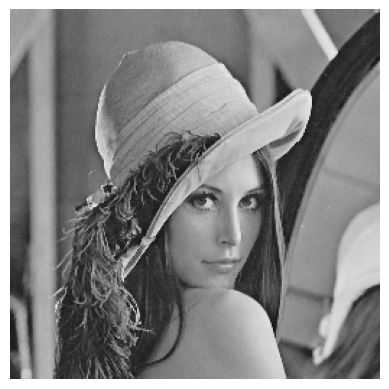

In [66]:
image = Image.open("lena.bmp")
image = image.convert("L")  # Convert to grayscale
image = np.array(image, dtype=np.float64)
image = image / 255.0

plt.imshow(image, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

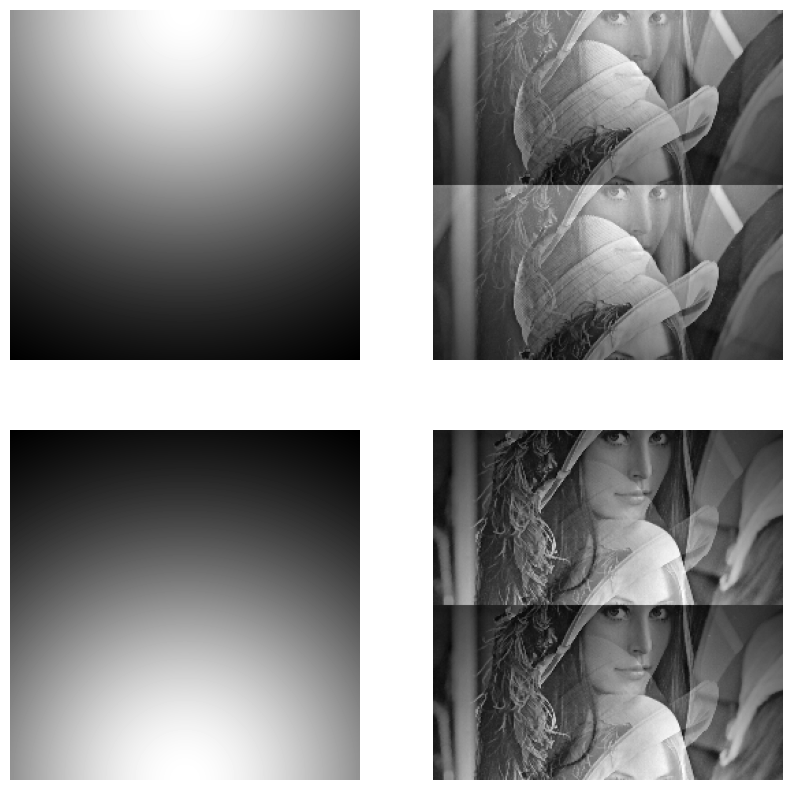

In [67]:
shading_a = shading_map(image.shape, center=(0.0, -1.0), sigma=1.0)
shading_b = shading_map(image.shape, center=(0.0, 1.0), sigma=1.0)
image_a = undersample_and_recover(image * shading_a)
image_b = undersample_and_recover(image * shading_b)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0][0].imshow(shading_a, cmap="gray")
axs[0][0].axis("off")
axs[1][0].imshow(shading_b, cmap="gray")
axs[1][0].axis("off")
axs[0][1].imshow(image_a, cmap="gray")
axs[0][1].axis("off")
axs[1][1].imshow(image_b, cmap="gray")
axs[1][1].axis("off")

The following section is the main interesting part.

Essentially, you can view the output image from undersampling in k-space as the sum of two copies, offset by a certain amount.
This follows from the Nyquist-Shannon sampling theorem. We require 256 x 256 datapoints in k-space to fully recover 256 x 256 datapoints in the image domain. Since we have blanked out half of the lines in k-space, our FOV is cut in half, meaning that the top half of the image "cuts in" from the bottom, and the bottom half of the image "cuts in" from the top. We will consider a pixel from the "original image" as having y-coordinate $y$ and its corresponding pixel from the aliased copy as having y-coordinate $y'$. In practice we will use $y' = mod(y + height / 2, height)$.

We can recover the original image almost perfectly just by having two physically separate coils with known sensitivity maps that are different. To see why, consider that at every point in our distorted images (given by $P[x, y]$), there are two scaled components, one from the top half of the image (given by $O[x, y]$), and the other from the bottom half of the image (given by $O[x, y']$). So $P[x, y] = aO[x, y] + bO[x, y']$. The values of $a$ and $b$ are given by the sensitivity map ($S[x, y]$) at that particular location. So $P[x, y] = S[x, y]O[x, y] + S[x, y']O[x, y']$.

We acquired two different distorted images using different sensitivity maps. So we get a system of equations given by $P_1[x, y] = S_1[x, y]O[x, y] + S_1[x, y']O[x, y']$ and $P_2[x, y] = S_2[x, y]O[x, y] + S_2[x, y']O[x, y']$. So long as the matrix
$$
\begin{bmatrix}
S_1[x, y] & S_1[x, y'] \\
 S_2[x, y] & S_2[x, y']
 \end{bmatrix}
 $$
is invertible, we may solve for $O[x, y]$ and $O[x, y']$. Essentially, we require differences in sensitivity along the direction we're undersampling and between $S_1$ and $S_2$. The details are some linear algebra that I'm not inclined to do at the moment.

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

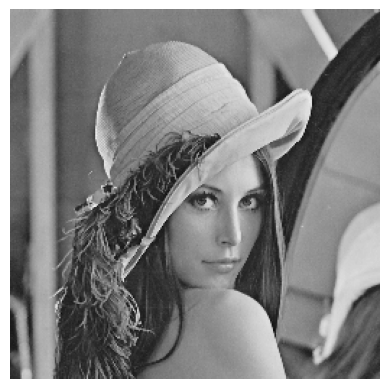

In [68]:
# Most of this is unreadable numpy nonsense, but it is very fast and works.

# Assembling the inverse matrix to recover the original image
y = np.arange(image.shape[0])
y_prime = (y + image.shape[0] // 2) % image.shape[0]
a = shading_a[y, :]
b = shading_a[y_prime, :]
c = shading_b[y, :]
d = shading_b[y_prime, :]
# In practice we assume that the inverse is well-defined, i.e., a*d - b*c != 0
det = 1.0 / (a*d - b*c)
# We have one inverse matrix per pixel
inv_mat = np.array([[d, -b], [-c, a]])
# Reshape the inverse matrix to (256, 256, 2, 2) so that inv_mat @ P does what we want (multiply each pixel by the corresponding inverse matrix)
inv_mat = np.transpose(inv_mat, (2, 3, 0, 1))
inv_mat = inv_mat * det[..., np.newaxis, np.newaxis]
# Assemble the column vector of the two images and reshape to (256, 256, 2, 1) for matrix multiplication
P = np.array([image_a, image_b])
P = np.transpose(P, (1, 2, 0))
P = P[..., np.newaxis]
# Multiply everything out, keep only the y image rather than the y' image. They're both valid, but the y' image would have to be shifted back
O = inv_mat @ P
o = O[:, :, 0, 0]
o = o / np.max(o)

plt.imshow(o, cmap="gray")
plt.axis("off")

Max error: 0.18%


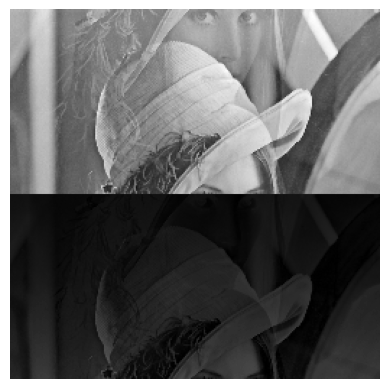

In [69]:
diff = np.abs(o - image)

plt.imshow(diff, cmap="gray")
plt.axis("off")

print(f"Max error: {np.max(diff) * 100:.2g}%")